In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import gc 
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
from tensorflow import keras
from matplotlib.image import imread
from sklearn.model_selection import train_test_split

In [10]:
path = "../input/planets-dataset/"
os.listdir(path)

['planet', 'test-jpg-additional']

In [11]:
#Loading the image datasets
train_path = '../input/planets-dataset/planet/planet/train_classes.csv'
test_path = '../input/planets-dataset/planet/planet/sample_submission.csv'
train_images = '../input/planets-dataset/planet/planet/train-jpg/'
test_images = '../input/planets-dataset/planet/planet/test-jpg/'

In [12]:
# Loading the train and test datasets
df_train = pd.read_csv(train_path)
print(df_train.shape)
df_train.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [13]:
# Loading the train and test datasets
df_test = pd.read_csv(test_path)
print(df_test.shape)
df_test.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [15]:
# Number of images in the dataset
print(f'Number of images: {df_train.shape[0]}')

Number of images: 40479


In [16]:
df_train["list_tags"] = df_train.tags.str.split(" ")
tags = df_train.list_tags.values
tags = [tag for row in tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame({"tag": counter_tags.keys(), "total": counter_tags.values()}).sort_values("total", ascending = False)

In [17]:
df_tags

,tag,total
1,primary,37513
3,clear,28431
2,agriculture,12315
6,road,8071
4,water,7411
10,partly_cloudy,7261
7,cultivation,4547
5,habitation,3660
0,haze,2697
9,cloudy,2089


In [18]:
df_train_copy = df_train

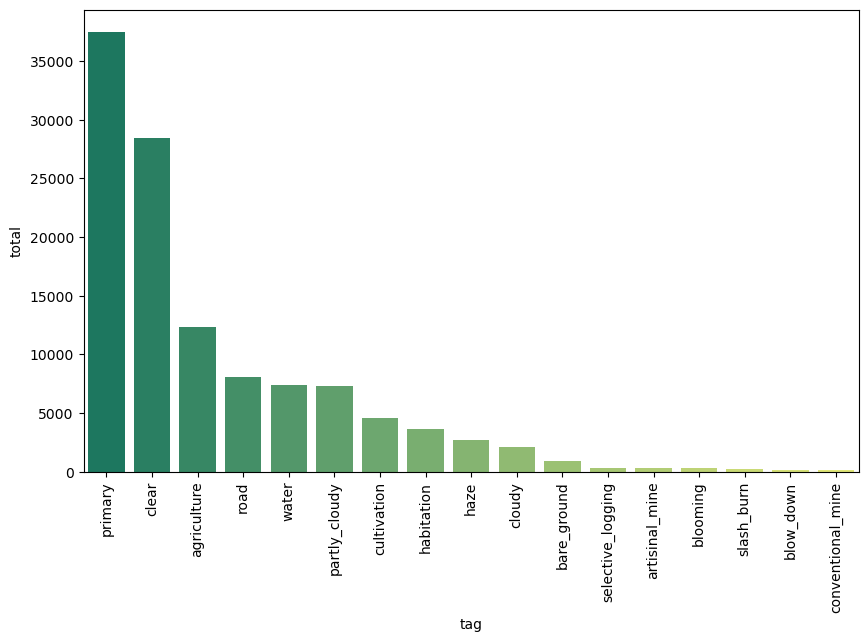

In [19]:
plt.figure(figsize = (10,6))
sns.barplot(x = df_tags.tag, y = df_tags.total, palette = 'summer')
plt.xticks(rotation = 90);

In [21]:
df_train1 = df_train.copy()

In [22]:
labels = list(df_tags.tag)
for tag in labels:
    df_train[tag] = df_train['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
df_train['image_name'] = df_train['image_name'].apply(lambda x: '{}.jpg'.format(x))
df_train.head()

,image_name,tags,list_tags,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,blow_down,conventional_mine
0,train_0.jpg,haze primary,"[haze, primary]",1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,"[agriculture, clear, primary, water]",1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,clear primary,"[clear, primary]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,"[clear, primary]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]",1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0


**CNN training**

In [23]:
# Define the columns
columns = list(df_train.columns[3:])
columns

['primary',
 'clear',
 'agriculture',
 'road',
 'water',
 'partly_cloudy',
 'cultivation',
 'habitation',
 'haze',
 'cloudy',
 'bare_ground',
 'selective_logging',
 'artisinal_mine',
 'blooming',
 'slash_burn',
 'blow_down',
 'conventional_mine']

In [24]:
from keras.preprocessing.image import ImageDataGenerator
# Initializing imagedatagenerator with a validation split of 0.2
train_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# Generating train data generator 
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory =train_images, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory =train_images, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [25]:
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

In [26]:
# import Library
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Create Model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (128,128,3)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(17, activation = 'softmax'))

# Define Optimizer
optimizer = Adam(learning_rate = 0.0001, beta_1=0.9, beta_2=0.999)

# Compile Model
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])

# Epochs And Batch Size
epochs = 20

In [27]:
from keras.callbacks import EarlyStopping 
# define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [28]:
# Fit the model 
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = val_generator,
                    validation_steps = step_val_size,
                    epochs = 20, 
                    callbacks = [earlystop])

Epoch 1/20
1012/1012 [==============================] - 611s 601ms/step - loss: 0.2447 - accuracy: 0.9307 - val_loss: 0.2810 - val_accuracy: 0.8514
Epoch 2/20
1012/1012 [==============================] - 580s 573ms/step - loss: 0.2083 - accuracy: 0.9320 - val_loss: 0.2324 - val_accuracy: 0.9102
Epoch 3/20
1012/1012 [==============================] - 574s 567ms/step - loss: 0.2008 - accuracy: 0.9194 - val_loss: 0.2377 - val_accuracy: 0.8462
Epoch 4/20
1012/1012 [==============================] - 574s 567ms/step - loss: 0.1949 - accuracy: 0.9163 - val_loss: 0.2125 - val_accuracy: 0.8634
Epoch 4: early stopping


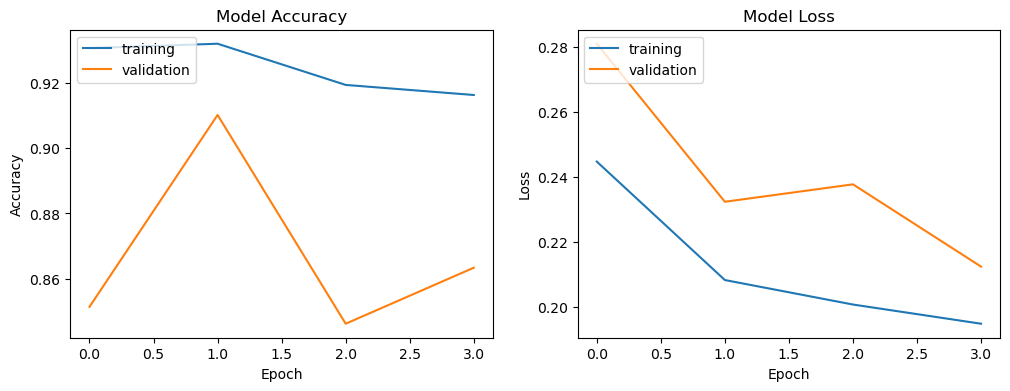

In [29]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()


In [30]:
# Loading the train and test datasets
df_test1 = df_test.drop('tags', axis = 1)

In [31]:
df_test1['image_name'] = df_test1['image_name'].apply(lambda x: '{}.jpg'.format(x))
df_test1.shape

(61191, 1)

In [32]:
#initialize imagedatagenerator for the test images and also rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

#creating a generator for the images found in the first test image files
test_gen = test_datagen.flow_from_dataframe(dataframe=df_test1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_gen.samples/test_gen.batch_size))


Found 40669 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 20522 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


In [33]:
test_gen.reset()
pred = model.predict(test_gen, steps=step_test_size1, verbose=1)

1271/1271 [==============================] - 318s 250ms/step


In [36]:
# Get the filenames in the generator using the attribute .filenames
file_names = test_gen.filenames

# Convert the predicted values to a dataframe and join two labels together if prob(occurrance of the label) > 0.5 
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: (np.array(labels)[np.argmax(x)]), axis = 1)
#pred_tags = pred_tags.apply(lambda x: labels[np.argmax(x)], axis=1)

# Convert Predictions classes to one hot vectors
#Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert Validation observation to one hot vectors
#Y_true = np.argmax(y_test, axis = 1)


#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
result1.head()

,image_name,tags
0,test_0.jpg,primary
1,test_1.jpg,primary
2,test_2.jpg,primary
3,test_3.jpg,primary
4,test_4.jpg,primary


In [37]:
result1.tags.value_counts()

primary          36015
cloudy            2481
clear             1560
haze               571
agriculture         25
water               12
partly_cloudy        5
Name: tags, dtype: int64

In [39]:
gc.collect()

8780

In [40]:
##adding .jpg extension to image name in the sample submission file
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_copy = sample_submission.copy()
sample_submission_copy['image_name'] = sample_submission_copy['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission_copy.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [41]:
# Divide the sample submission file into two splits,
# first test1_df contains the first 40669 images 
sample_sub_df1 = sample_submission_copy.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
sample_sub_df1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [42]:
#initialize imagedatagenerator for the test images and also rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

#creating a generator for the images found in the first test image files
test_gen = test_datagen.flow_from_dataframe(dataframe=sample_sub_df1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_gen.samples/test_gen.batch_size))

Found 40669 validated image filenames.


In [43]:
#first, we reset the test generator to avoid shuffling of index 
test_gen.reset()
pred = model.predict(test_gen, steps=step_test_size1, verbose=1)

1271/1271 [==============================] - 198s 156ms/step


In [44]:
# Get the filenames in the generator using the attribute .filenames
file_names = test_gen.filenames

# Convert the predicted values to a dataframe and join two labels together if prob(occurrance of the label) > 0.5 
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
result1.head()

,image_name,tags
0,test_0.jpg,primary
1,test_1.jpg,primary
2,test_2.jpg,primary
3,test_3.jpg,primary
4,test_4.jpg,


In [45]:
#second split of submission
sample_sub_df2 = sample_submission_copy.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
sample_sub_df2.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [46]:
#creating a generator for the second batch of test image files
test_gen1 = test_datagen.flow_from_dataframe(dataframe=sample_sub_df2, 
                                                directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col='image_name', 
                                                y_col=None, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

step_test_size2 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))

Found 20522 validated image filenames.


In [47]:
#we reset the generator to avoid shuffling, then make prediction on the generator
test_gen1.reset()
pred1 = model.predict(test_gen1, steps = step_test_size2, verbose = 1)

642/642 [==============================] - 165s 257ms/step


In [48]:
#this is to get the filenames in the generator using the attribute .filenames
file_names1 = test_gen1.filenames

#convert the predicted values to a dataframe
#join two labels together if the prob(occurrance of the label) > 0.5
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ''.join(np.array(labels)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result2.head()

,image_name,tags
0,file_0.jpg,primary
1,file_1.jpg,
2,file_10.jpg,
3,file_100.jpg,primary
4,file_1000.jpg,primary


In [49]:
final_df = pd.concat([result1, result2])

final_df = final_df.reset_index().drop('index', axis =1)

print(final_df.shape)
final_df.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,primary
1,test_1.jpg,primary
2,test_2.jpg,primary
3,test_3.jpg,primary
4,test_4.jpg,


In [50]:
# Remove the .jpg extension from the image_name of the last_result 
final_df['image_name'] = final_df['image_name'].apply(lambda x: x[:-4])
final_df.head()

,image_name,tags
0,test_0,primary
1,test_1,primary
2,test_2,primary
3,test_3,primary
4,test_4,
